# Homework 2: Trees and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom.**

**There are a lot of applied questions based on the code results. Please make sure to answer them all. These are primarily to test your understanding of the results your code generate (similar to any Data Science/ML case study interviews).**

Due Date : 10/14 (October 14th), 11:59 PM EST

## Name: Aaron Zhao

## UNI: sz2940

## The Dataset

### Acknowledgements

Big Thanks to https://www.superdatascience.com/pages/deep-learning

Banner Photo by Sharon McCutcheon on Unsplash

### Description

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Question 1: Decision Trees

**1.1: Load the provided dataset**

In [2]:
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.svm import LinearSVC , SVC
from sklearn.metrics import accuracy_score
import warnings

def warning_test():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warning_test()

pd.options.mode.chained_assignment = None

dt_df = pd.read_csv('HW2_dataset.csv')
dt_df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619.0,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608.0,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502.0,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699.0,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850.0,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771.0,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516.0,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709.0,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772.0,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


**1.2: Plot % of missing values in each column. Would you consider dropping any columns? Assuming we want to train a decision tree, would you consider imputing the missing values? If not, why? (Remove the columns that you consider dropping)**

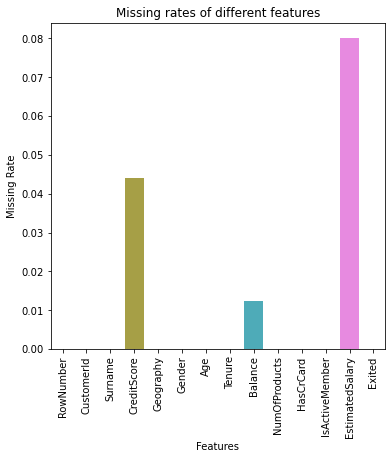

In [3]:
from sklearn.impute import SimpleImputer
missing_rate = np.sum(dt_df.isna(), axis = 0).values/dt_df.shape[0]
SI = SimpleImputer(strategy = 'most_frequent')

dt_df_imputed = pd.DataFrame(SI.fit_transform(dt_df), columns = dt_df.columns)

fig,ax = plt.subplots(figsize=(6,6))
sns.barplot(x = dt_df.columns[missing_rate >= 0].tolist(), y = missing_rate[missing_rate>=0].tolist(),ax =ax)
ax.tick_params(axis = 'x', rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('Missing Rate')
ax.set_title('Missing rates of different features')
plt.show()
# dt_df_imputed = dt_df_imputed.drop(columns = ['EstimatedSalary'], axis = 1)

All the features have low missing rates, even though the missing 
rate of the EstimatedSalary reached 0.08. I actually do not want to drop any column because
they are all useful and we only have around 10 columns.
We will impute the missing value as decision trees can not classsify samples if some features are missing.
I dont have to actually impute the values by myself since the decision model will impute the values for us

**1.3: Plot side-by-side bars of class distribtuion for each category for the categorical feature and the target categories.**

**Clarification with Example below : Here `flWinner` is the Target Variable and `descMapName` is a categorical feature. You are required to make such side-by-side bar plot for each categorical feature with repect to it's class distribution with the target feature for our dataset.**

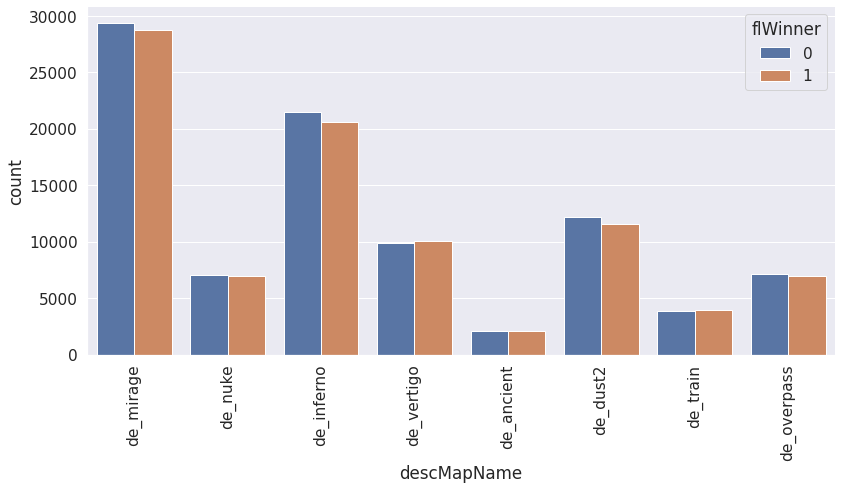

Text(0.5, 1.0, 'Distribution of feature Gender')

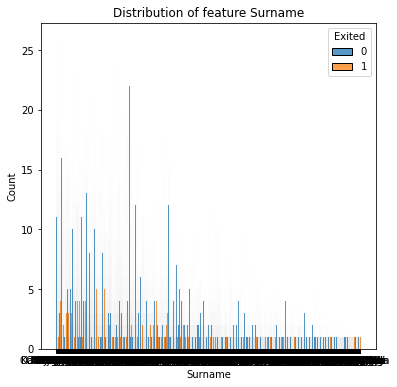

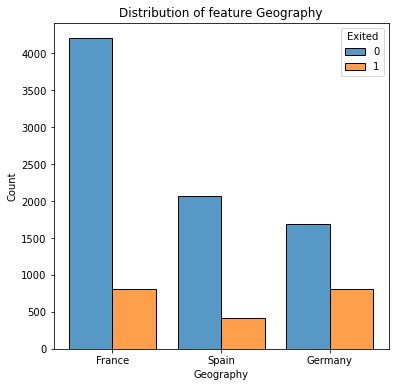

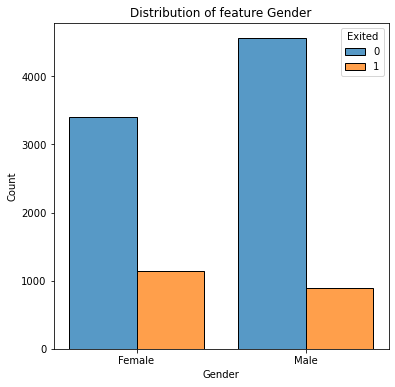

In [4]:
fig, ax = plt.subplots(figsize = (6,6))
sns.histplot(x = dt_df.Surname, hue = dt_df.Exited, multiple = 'dodge', shrink = 0.8)
ax.set_xlabel('Surname')
ax.set_ylabel('Count')
ax.set_title('Distribution of feature Surname')

fig, ax = plt.subplots(figsize = (6,6))
sns.histplot(x = dt_df.Geography, hue = dt_df.Exited, multiple = 'dodge', shrink = 0.8)
ax.set_xlabel('Geography')
ax.set_ylabel('Count')
ax.set_title('Distribution of feature Geography')

fig, ax = plt.subplots(figsize = (6,6))
sns.histplot(x = dt_df.Gender, hue = dt_df.Exited, multiple = 'dodge', shrink = 0.8)
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Distribution of feature Gender')

**1.4: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

I used train_test_aplit with random_state and stratify to make sure the train and test sets are
splitted based on the orginal Exited ratio and the outcome have more authenticity

In [5]:
dt_df_X = dt_df_imputed.drop(columns = ['Exited','Surname'])
dt_df_y = dt_df_imputed['Exited'].astype(float)

dt_X_dev, dt_X_test, dt_y_dev, dt_y_test = \
train_test_split(dt_df_X, dt_df_y, train_size = 0.8, random_state = 2511, stratify = dt_df_y)

**1.5: Preprocess the data (Handle the Categorical Variable). Do we need to apply scaling? Briefly Justify**

In [6]:
from sklearn.compose import make_column_transformer

# num_features = dt_X_dev.columns.values.tolist()

# #Geography & Gender cleanup
# dt_X_dev = pd.get_dummies(dt_X_dev, columns=["Geography", "Gender"])
# dt_X_test = pd.get_dummies(dt_X_test, columns=["Geography", "Gender"])
# # #Surname cleanup
# dt_X_dev = dt_X_dev.drop(columns = ['Surname'])
# dt_X_test = dt_X_test.drop(columns = ['Surname'])

In [7]:
from sklearn.compose import make_column_transformer
num_features = dt_df_X.columns.values.tolist()
num_features.remove('Geography')
num_features.remove('Gender')

ohe_features = ['Geography','Gender']
preprocess = make_column_transformer((StandardScaler(), num_features),
                                    (OneHotEncoder(handle_unknown = 'ignore'),ohe_features),
                                    remainder = 'passthrough')

dt_X_dev = preprocess.fit_transform(dt_X_dev)
dt_X_dev_name = preprocess.get_feature_names_out()
dt_X_test = preprocess.transform(dt_X_test)

#We need to apply scaling for numerical features as some features have higher values.

**1.6: Fit a Decision Tree on the development data until all leaves are pure. What is the performance of the tree on the development set and test set? Provide metrics you believe are relevant and briefly justify.**

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
DTC = DecisionTreeClassifier(random_state=2511)
DTC.fit(dt_X_dev,dt_y_dev) 
print('Decision Tree train accuracy: {}'.format(DTC.score(dt_X_dev,dt_y_dev)))
print('Decision Tree test accuracy: {}'.format(DTC.score(dt_X_test,dt_y_test)))

Decision Tree train accuracy: 1.0
Decision Tree test accuracy: 0.796


**1.7: Visualize the trained tree until the max_depth 8**

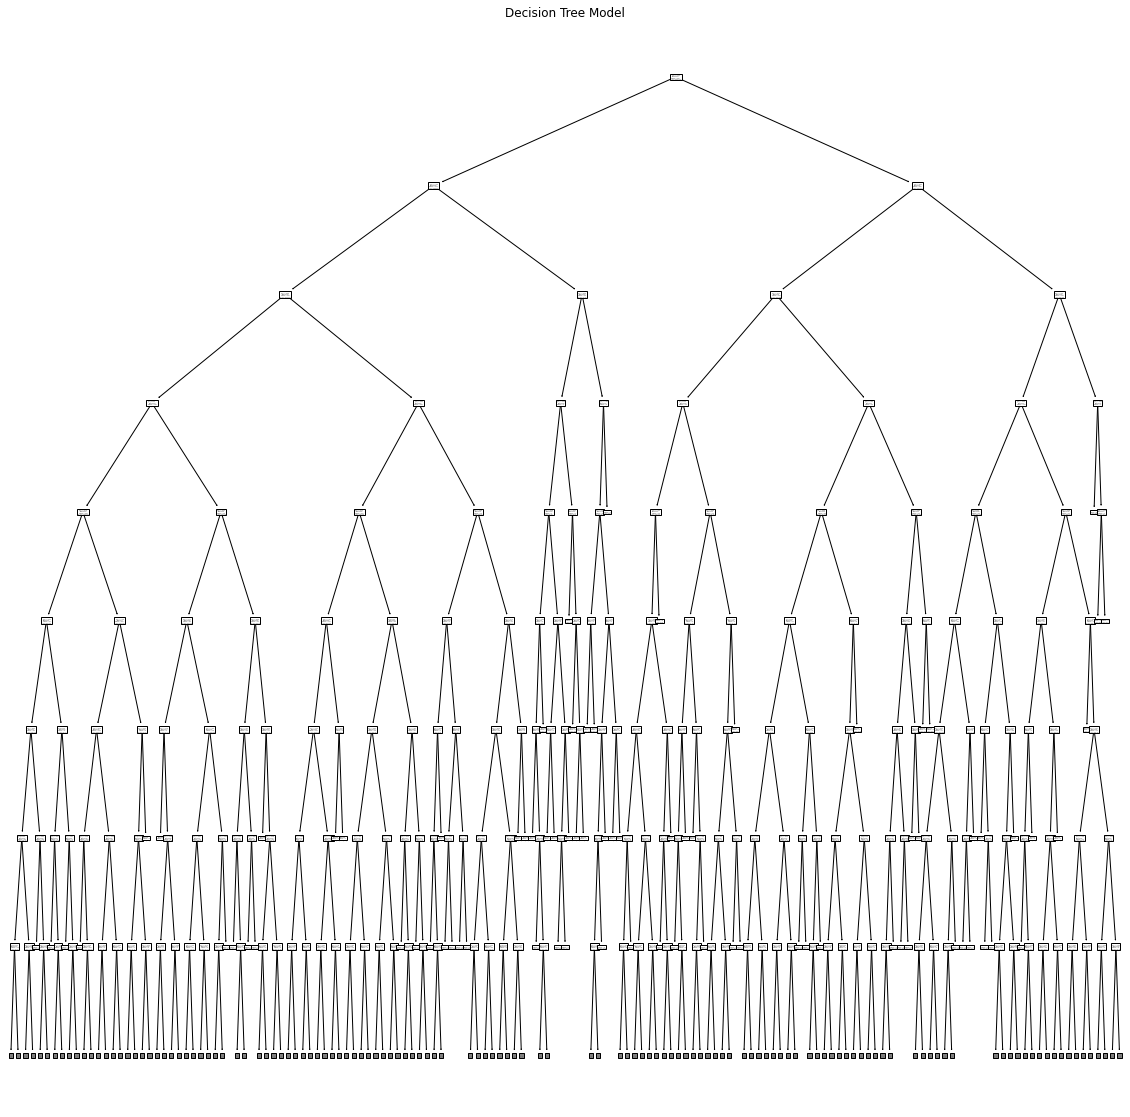

In [9]:
from sklearn.tree import plot_tree
fig,ax = plt.subplots(figsize=(20, 20))
plot_tree(DTC, max_depth = 8, ax = ax)
ax.set_title('Decision Tree Model')
plt.show()

**1.8: Prune the tree using one of the techniques discussed in class and evaluate the performance**

In [10]:
path = DTC.cost_complexity_pruning_path(dt_X_dev,dt_y_dev)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
DTC2 = DecisionTreeClassifier(random_state=2511, ccp_alpha = np.median(ccp_alphas))
DTC2.fit(dt_X_dev,dt_y_dev) 
print('Ccp alpha: {}'.format(np.median(ccp_alphas)))
print('Decision Tree train accuracy: {}'.format(DTC2.score(dt_X_dev,dt_y_dev)))
print('Decision Tree test accuracy: {}'.format(DTC2.score(dt_X_test,dt_y_test)))

Ccp alpha: 0.00019999999999999996
Decision Tree train accuracy: 0.953
Decision Tree test accuracy: 0.8175


**1.9: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/imac/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


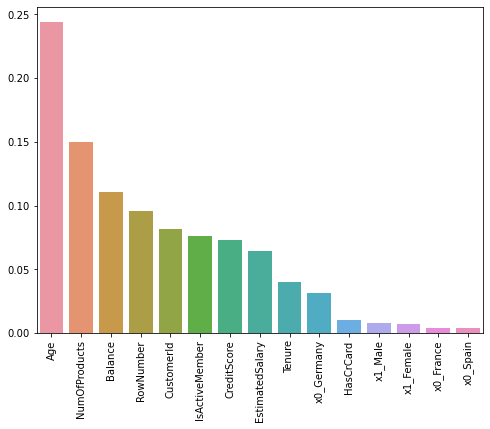

In [11]:
from sklearn.preprocessing import OneHotEncoder
ohe_feature_names = preprocess.named_transformers_['onehotencoder'].get_feature_names()
feature_names = num_features + ohe_feature_names.tolist()
feat_imps = zip(feature_names, DTC2.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x:x[1]!= 0, feat_imps)),key = lambda x:x[1], reverse = True)))
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(list(feats),list(imps))
ax.tick_params(axis = 'x', rotation = 90)

## Question 2: Random Forests

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.6)?**

In [12]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state = 2511)
RFC.fit(dt_X_dev,dt_y_dev) 
print('Decision Tree train accuracy: {}'.format(RFC.score(dt_X_dev,dt_y_dev)))
print('Decision Tree test accuracy: {}'.format(RFC.score(dt_X_test,dt_y_test)))

Decision Tree train accuracy: 1.0
Decision Tree test accuracy: 0.8615


the accuracy of the training dataset is perfect and the performance of predicting test improved

**2.2: Does all trees in the trained random forest model have pure leaves? How would you verify this?**

The trained random forest model have pure leaves, because we do not restrict the depth. In order to verify this, we need to check every tree and to see if all their leaves are pure. We first explore all trees and find their leave index, then we check if their impurities is all 0.

In [13]:
impurity_count = 0
for sub_tree in RFC.estimators_:
    n_nodes = sub_tree.tree_.node_count
    # to find index of leaf node
    leaf_index = []
    left_logic = sub_tree.tree_.children_left <0
    right_logic = sub_tree.tree_.children_right <0
    for i in range(n_nodes):
        if (left_logic[i] != right_logic[i]):
            leaf_index.append(i) 
    
    if(sum(sub_tree.tree_.impurity[leaf_index])==0):# pure tree
        impurity_count += 1 
        
print('All {} trees out of 100 trees are pure'.format(impurity_count))

All 100 trees out of 100 trees are pure


**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


I would use n_estimator and max_depth. The reason is the above model is clearly overfitting.
We need to restrict the model to solve overfitting

**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

I can just simply set n_estimator to be [100, 200, 300, 400, 500], max_depth to be [5, 10, 15, 20, 25]

**2.5: Perform model selection using the chosen values for the hyperparameters. Use cross-validation for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [14]:
dt_X_train, dt_X_val, dt_y_train, dt_y_val = \
train_test_split(dt_X_dev, dt_y_dev, train_size = 0.75,random_state = 2511,stratify = dt_y_dev)

best_n_estimator = -1
best_depth = -1
best_score = 0

for n_estimator in [100, 200, 300, 400, 500]:
    for max_depth in [5, 10, 15, 20, 25]:
        RFC = RandomForestClassifier(random_state = 2511, n_estimators = n_estimator, max_depth = max_depth)
        RFC.fit(dt_X_train,dt_y_train) 
        val_score = RFC.score(dt_X_val,dt_y_val)
        if(val_score > best_score):
            best_score = val_score
            best_n_estimator = n_estimator
            best_depth = max_depth
            train_score = RFC.score(dt_X_train,dt_y_train)

best_RFC = RandomForestClassifier(random_state = 2511, n_estimators = best_n_estimator, max_depth = best_depth)
best_RFC.fit(dt_X_train,dt_y_train)
test_score = best_RFC.score(dt_X_test,dt_y_test)


print('Best n_estimators: {} depth: {}'.format(best_n_estimator,best_depth))       
print('Best training accuracy: {}'.format(train_score))
print('Best validation accuracy: {}'.format(best_score))
print('Best testing accuracy: {}'.format(test_score))

Best n_estimators: 200 depth: 15
Best training accuracy: 0.9865
Best validation accuracy: 0.867
Best testing accuracy: 0.859


The performance is better than our random forest model trained in Q2.1.

**2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.9? If they differ, which feature set makes more sense?**

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


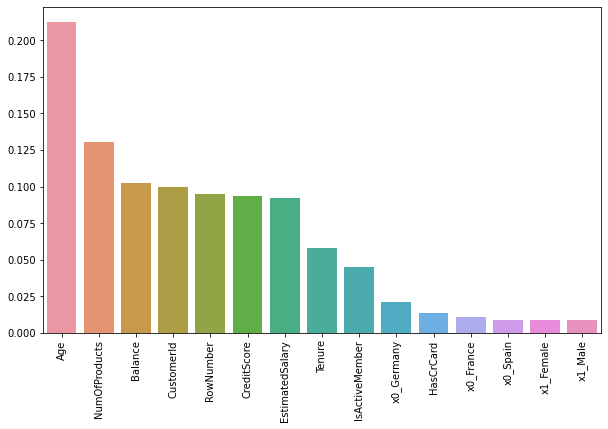

In [15]:
feat_imps = zip(feature_names, best_RFC.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x:x[1]!= 0, feat_imps)),key = lambda x:x[1], reverse = True)))
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(list(feats),list(imps))
ax.tick_params(axis = 'x', rotation = 90)

The top three most import features are Age, NumberOfProducts, Balance.
The top 3 features remain the same. 

## Question 3: Gradient Boosted Trees

**3.1: Choose three hyperparameters to tune GradientBoostingClassifier and HistGradientBoostingClassifier on the development dataset using 5-fold cross validation. Report on the time taken to do model selection for both the models. Also, report the performance of the test dataset from the optimal models.**

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import time 

/Users/imac/opt/anaconda3/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [17]:
# GradientBoostingClassifier we choose n_estimator, learning_rate and max depth
time_start = time.time()
n_estimators = [100,200]
max_depth = [4,5]
learning_rate  = [0.15,0.1]
pipe = GridSearchCV(GradientBoostingClassifier(random_state = 2511)
                    ,param_grid = {'n_estimators':n_estimators,
                                   'learning_rate': learning_rate,
                                   'max_depth': max_depth},
                                   return_train_score = True, cv = 5)
pipe.fit(dt_X_dev,dt_y_dev)
print(f'Best score:', pipe.best_score_)
print(f'Best params:', pipe.best_params_)
print(f'Test score:', pipe.score(dt_X_test,dt_y_test))
time_end = time.time()
print('Time cost',time_end - time_start,'s')

Best score: 0.8622500000000001
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Test score: 0.8605
Time cost 83.42258191108704 s


The results are below. We can see that although it cost long time to train this model,
we still got some improvements.

In [18]:
import warnings
warnings.filterwarnings('ignore')

time_start = time.time()
max_iter = [100, 200]
loss = ['auto', 'binary_crossentropy', 'categorical_crossentropy']
learning_rate  = [0.15, 0.1]
pipe = GridSearchCV(HistGradientBoostingClassifier(random_state = 2511)
                    ,param_grid = {'max_iter':max_iter,
                                   'learning_rate': learning_rate,
                                   'loss': loss},
                                   return_train_score = True, cv = 5)
pipe.fit(dt_X_dev,dt_y_dev)
print(f'Best score:', pipe.best_score_)
print(f'Best params:', pipe.best_params_)
print(f'Test score:', pipe.score(dt_X_test,dt_y_test))
time_end = time.time()
print('Time cost',time_end - time_start,'s')


Best score: 0.8615
Best params: {'learning_rate': 0.1, 'loss': 'auto', 'max_iter': 100}
Test score: 0.859
Time cost 417.0789723396301 s


For HistGradientBoostingClassifier, the training time is shorter and model has a good performance.

**3.2: Train an XGBoost model by tuning 3 hyperparameters using 10 fold cross-validation. Compare the performance of the trained XGBoost model on the test dataset against the performances obtained from 3.1**

In [19]:
import warnings
warnings.filterwarnings('ignore')
time_start = time.time()
from xgboost import XGBClassifier
n_estimators = [100,200,300]
max_depth = [4,5,6]
learning_rate  = [0.01,0.15,0.1]
pipe = GridSearchCV(XGBClassifier(random_state = 2511)
                    ,param_grid = {'n_estimators':n_estimators,
                                   'learning_rate': learning_rate,
                                   'max_depth': max_depth},
                                   return_train_score = True, cv = 5)
pipe.fit(dt_X_dev,dt_y_dev)
print(f'Best score:', pipe.best_score_)
print(f'Best params:', pipe.best_params_)
print(f'Test score:', pipe.score(dt_X_test,dt_y_test))
time_end = time.time()
print('Time cost',time_end - time_start,'s')


Best score: 0.8647500000000001
Best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Test score: 0.863
Time cost 201.9532561302185 s


the performance is a little bit better than models trained before.

**3.3: Compare the results on the test dataset from XGBoost, HistGradientBoostingClassifier, GradientBoostingClassifier with results from Q1.6 and Q2.1. Which model tends to perform the best and which one does the worst? How big is the difference between the two? Which model would you choose among these 5 models and why?**

The XGBoost model returned the highest score while the model in 1.6 has the lowest score.
The difference is 0.069.
I would choose XGBoost model since it returned the best performance and the running time is relatively low.

**3.4: Can you list the top 3 features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree? Which one would you trust the most?**

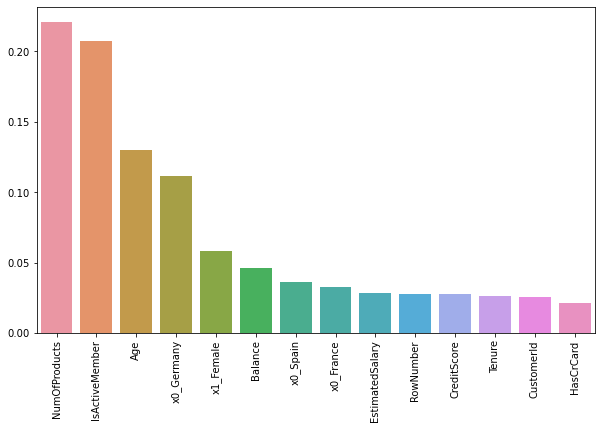

In [20]:
import warnings
warnings.filterwarnings('ignore')

best_XGB = XGBClassifier(random_state = 2511, n_estimators = 300, max_depth = 4, learning_rate = 0.15)
best_XGB.fit(dt_X_dev,dt_y_dev)
feat_imps = zip(feature_names, best_XGB.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x:x[1]!= 0, feat_imps)),key = lambda x:x[1], reverse = True)))
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(list(feats),list(imps))
ax.tick_params(axis = 'x', rotation = 90)

The top three most important features are NumberOfProducts, IsActiveMember, Age. The top 2 features are NumberOfProducts adn IsActiveMember. The third most important feature is Age now. In the previous chart,
the IsActiveMember was ranked 6th, 7th. But it is now ranked 2nd place in this model.
I will choose because it gives me a relatively very accurate outcome and the IsActiveMember should have a 
high position because it has a very strong relationship with whether the customer exited or not.

**3.5: Can you choose the top 7 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [50]:
reduced_features = list(feats[0:7])

# print(dt_X_dev.type)
dt_X_dev_1 = []
for j in dt_X_dev:
    j = np.delete(j, [0,1,2,4,7,9,10,14])
    dt_X_dev_1.append(j,)
    

dt_X_dev_1[0]



array([-0.56392586, -1.20730398,  0.800032  , -1.02199176,  0.        ,
        0.        ,  0.        ])

In [52]:
dt_X_test_1 = []
for j in dt_X_test:
    j = np.delete(j, [0,1,2,4,7,9,10,14])
    dt_X_test_1.append(j,)
    

In [53]:

# print(reduced_features)
# print(dt_X_dev_name)
# print('\n')
# print(np.delete(dt_X_dev, None, ))
# reduced_dt_X = dt_X_dev[:,3:5:6:8:11:12:13]
# reduced_dt_X_dev, reduced_dt_X_test, reduced_dt_y_dev, reduced_dt_y_test = \
# train_test_split(reduced_dt_X , dt_df_y, train_size = 0.8,random_state = 2511, stratify = dt_df_y)

# preprocess = make_column_transformer((StandardScaler(), reduced_features),
#                                     remainder = 'passthrough')
# reduced_tb_X_dev = preprocess.fit_transform(reduced_dt_X_dev)
# reduced_tb_X_test = preprocess.transform(reduced_dt_X_test)



reduced_dt_X_dev = dt_X_dev_1
reduced_dt_X_test = dt_X_test_1

import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
n_estimators = [100,200,300]
max_depth = [4,5,6]
learning_rate  = [0.01,0.15,0.1]
pipe = GridSearchCV(XGBClassifier(random_state = 2511)
                    ,param_grid = {'n_estimators':n_estimators,
                                   'learning_rate': learning_rate,
                                   'max_depth': max_depth},
                                   return_train_score = True, cv = 5)
pipe.fit(reduced_dt_X_dev, dt_y_dev)
print(f'Best score:', pipe.best_score_)
print(f'Best params:', pipe.best_params_)
print(f'Test score:', pipe.score(reduced_dt_X_test, dt_y_test))


Best score: 0.865625
Best params: {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 100}
Test score: 0.8625


The reduced model performance is a little worse than the best score even though we only used the most important 7 features. Prob the reason is other features actually contain some useful info.

## Question 4: Calibration

**4.1: Estimate the brier score for the XGBoost model (trained with optimal hyperparameters from Q3.2) scored on the test dataset.**

In [23]:
def estimate_brier_score(y_true,y_prob):
    res = 0
    for i in range(len(y_true)):
        res += (y_prob[i,1] - y_true[i])**2
    return res/len(y_true)

from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay

print('Brier score: {}'.format(estimate_brier_score(np.array(dt_y_test), best_XGB.predict_proba(dt_X_test))))


Brier score: 0.10544399372364753


**4.2: Calibrate the trained XGBoost model using isotonic regression as well as Platt scaling. Plot predicted v.s. actual on test datasets from both the calibration methods**

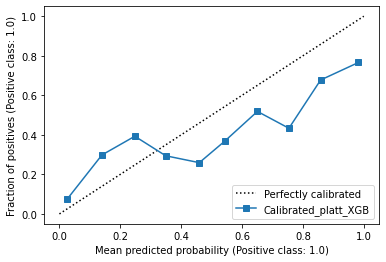

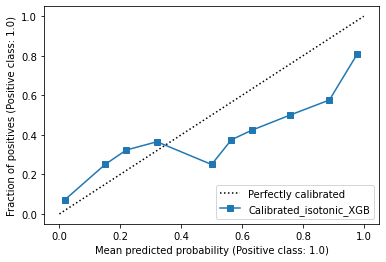

In [24]:
from sklearn.calibration import CalibratedClassifierCV
best_XGB = XGBClassifier(random_state = 2511, n_estimators = 300, max_depth = 4, learning_rate = 0.15)
best_XGB.fit(dt_X_dev, dt_y_dev)
platt_xgb = CalibratedClassifierCV(best_XGB, cv = 'prefit', method = 'sigmoid')
platt_xgb.fit(dt_X_dev, dt_y_dev)
display = CalibrationDisplay.from_estimator(
    platt_xgb, dt_X_test, dt_y_test, n_bins = 10, name = 'Calibrated_platt_XGB')

best_XGB = XGBClassifier(random_state = 2511, n_estimators = 300, max_depth = 4, learning_rate = 0.15)
best_XGB.fit(dt_X_dev, dt_y_dev)
isotonic_xgb = CalibratedClassifierCV(best_XGB, cv = 'prefit', method = 'isotonic')
isotonic_xgb.fit(dt_X_dev, dt_y_dev)
display = CalibrationDisplay.from_estimator(
    isotonic_xgb, dt_X_test, dt_y_test, n_bins = 10, name = 'Calibrated_isotonic_XGB')

**4.3: Report brier scores from both the calibration methods. Do the calibration methods help in having better predicted probabilities?**

In [26]:
print('Brier score of platt calibration: {}'.format(estimate_brier_score(np.array(dt_y_test), platt_xgb.predict_proba(dt_X_test))))
print('Brier score of isotonic calibration: {}'.format(estimate_brier_score(np.array(dt_y_test), isotonic_xgb.predict_proba(dt_X_test))))


Brier score of platt calibration: 0.11841945685544371
Brier score of isotonic calibration: 0.11721467196629899


Although i tried to calibrate the data, the calibration methods are not helping in having better predicted probabilities.
probably the model is good enough and dont need any further changes.